## CNN Cancer Detection - Kaggle Mini Competition

For module 3, we are asked to develop a model based on CNN architecture for a kaggle competition.
The competition is a binary classification problem that takes 96x96x3 color photos and makes a prediction of if the photo has cancer in it.

Important note: Due to the size of the training and test data, This notebook was written in Kaggle and then exported as a notebook. The exported version does not contain the visualizations and plots for training.

To view the notebook with all of the graphical data please visit:

https://www.kaggle.com/code/guymcguy/arj-cnn-cancerdetection

version 6 is the final version.

In [1]:
# Import useful libraries for EDA and importation of data

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os





#### Step 1

The problem is fundementally a binary classification problem (Has cancer/Has no cancer).
We will briefly look at the shape of the data.
Due to the imbalance of the dataset, some initial data wrangling and rebalancing will be performed.

In [2]:
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)

print('Training Shape:',train_labels.shape)
print('Input example :')
train_labels.head()

Training Shape: (220025, 2)
Input example :


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# We will cast the input labels as float type instead of object

train_labels['label'] = train_labels['label'].astype(float)

In [4]:
# Look at Test/Train size difference

print('Training samples: ',len(os.listdir('../input/histopathologic-cancer-detection/train/')))
print('Test samples: ',len(os.listdir('../input/histopathologic-cancer-detection/test/')))

TrainProportion = len(os.listdir('../input/histopathologic-cancer-detection/train/'))/ (len(os.listdir('../input/histopathologic-cancer-detection/train/')) + len(os.listdir('../input/histopathologic-cancer-detection/test/')))

print('Proportion of data in Train set: ',TrainProportion)
print('Proportion of data in Test set: ',1- TrainProportion)

Training samples:  220025


Test samples:  57458


Proportion of data in Train set:  0.7929314588641466
Proportion of data in Test set:  0.20706854113585338


#### Step 2 : EDA

Begin EDA and refine data for model

<AxesSubplot:title={'center':'Distribution of Binary Classes'}>

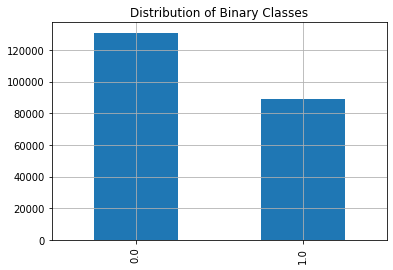

In [5]:
# Establish distribution of training labels

train_labels['label'].value_counts()
train_labels['label'].value_counts().plot(kind='bar',grid=True,title='Distribution of Binary Classes')

Imbalanced data will need to be dealt with. Since Negative cases outweight positive cases, we will sample len(pos) cases from the negative cases.

In [6]:
# Make occurence of 0s equivalent to 1s in the training data

train_pos = train_labels[train_labels['label'] == 1]
train_neg = train_labels[train_labels['label'] == 0]
train_neg = train_neg.sample(n = len(train_pos))

# Check new sizes
print(len(train_neg))
print(len(train_pos))

89117
89117


<AxesSubplot:title={'center':'Balnced Data'}, ylabel='label'>

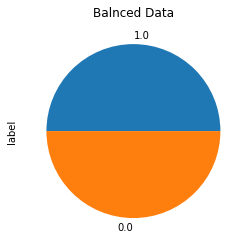

In [7]:
# Concat two datasets, confirm new set is balance w/ Pie chart

train_bal = pd.concat([train_neg,train_pos]).sample(frac=1, random_state=42).reset_index(drop=True)
train_bal.head()

train_bal['label'].value_counts().plot(kind='pie',title='Balnced Data')


With the training dataset balanced we are now ready to look at some sample photos.
We will Import Matplotlib functions for plotting images and look at a few.

Shape of image: (96, 96, 3)


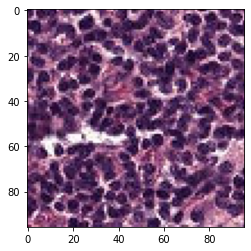

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_bal.iloc[1,0]}.tif')
imgplot = plt.imshow(img)

print('Shape of image:', img.shape)

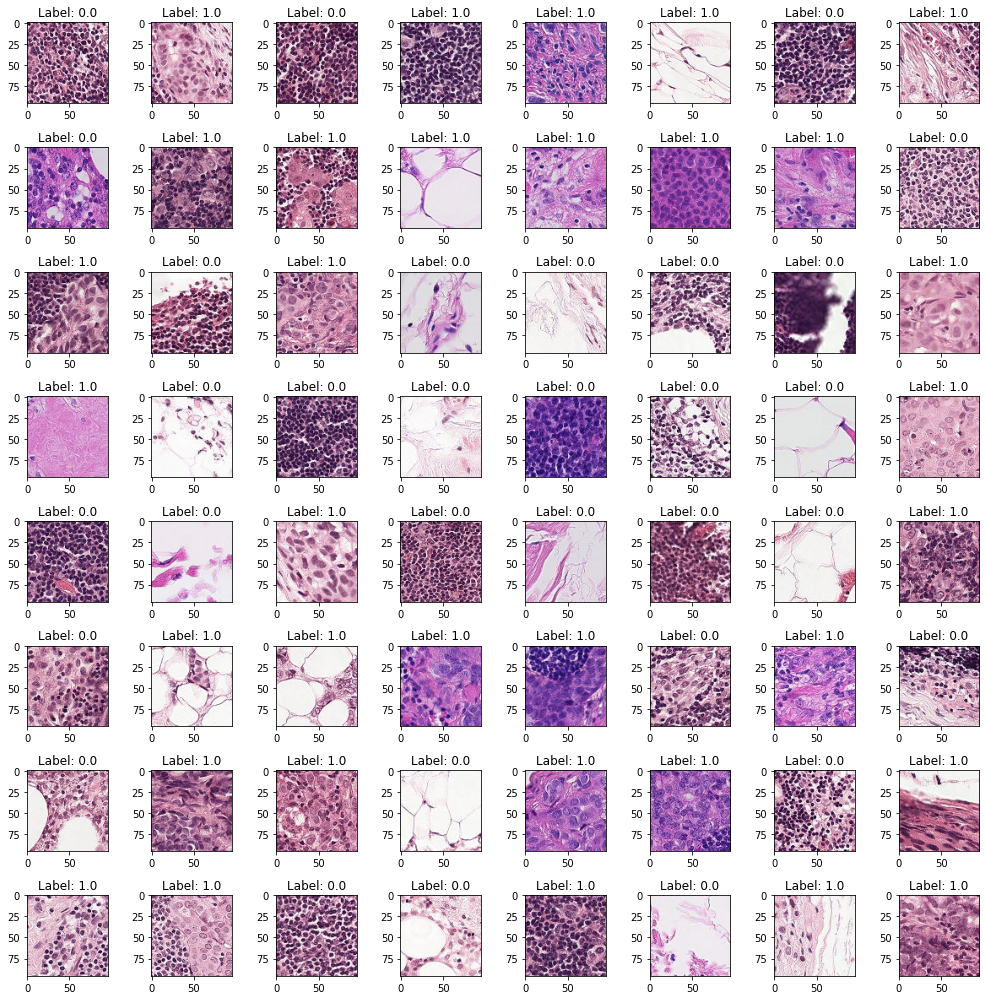

In [9]:
# Plot array of photos w/ Labels

rndm_img = np.random.choice(train_bal.index,64)
fig, ax = plt.subplots(8, 8,figsize=(14,14))

for i in range(0, rndm_img.shape[0]):
    ax = plt.subplot(8, 8, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_bal.iloc[rndm_img[i],0]}.tif')
    ax.imshow(img)
    label = train_bal.iloc[rndm_img[i],1]
    ax.set_title('Label: %s'%label)
    
plt.tight_layout()

Clearly the training data images are very diverse in appearance. To an untrained eye (mine own) a 50% success rate of predicting a cancerous image vs. non cancerous would be expected. With the availability of CNN to learn the image labels we seek to improve from the 50% benchmark.

## Step 3 -  Model Design

From lecture notes, we recall that the VGGnet architecture consisted of repeated Conv-Conv-MaxPool. My plan is to deploy an initial model with VGGNet architecture and then further refine.

I will Then seek to deploy a deeper network to see if more layers help train a more robust model. To address the vanishing gradients I will leverage Residual connections in a ConvConvPool structure. I will make a deep model and then tune hyper parameters to find the best model based on accuracy.


In [10]:
# Import Tensorflow and Keras Libraries, sklearn test/train split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
# Libraries for making a ResNet
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split


In [11]:
# Split the Data
train_df, val_df = train_test_split(train_bal, test_size=0.2, random_state=42, 
                                      stratify=train_bal.label)

In [12]:
# Create labels for model

# Train
train_df['id'] = train_df['id']+'.tif'
train_df['label'] = train_df['label'].astype(str)
print(train_df.shape)
# Test
val_df['id'] = val_df['id']+'.tif'
val_df['label'] = val_df['label'].astype(str)

(142587, 2)


We will need an image generator for the image data because loading all images to memory will kill the notebook.



In [ ]:
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255) # To adjust pixel contents between 0/1
train_generator=train_datagen.flow_from_dataframe(dataframe=train_df, directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))
valid_generator=train_datagen.flow_from_dataframe(dataframe=val_df, directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

Begin Model building:

In [ ]:
# First model : 4x blocks of 2 convolutional layers w/ a pooling at end.

model = Sequential()
# L1
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# L2
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
#L3
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
#L4
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Flatten & Dense          
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))
# Dense 2
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))
# Dense 3
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu')) 
# Final Actization
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

General Note on Training:

W/ 1.8M parameters, training on CPU will be snail-like at best. The use of a GPU is advised. I'm training on K80 curtosy of Kaggle hardware accelerators

In [ ]:
train_step=train_generator.n//train_generator.batch_size
val_step=valid_generator.n//valid_generator.batch_size


history_VGG = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=15, verbose=1
)

In [ ]:
plt.plot(history_VGG.history['accuracy'])
plt.plot(history_VGG.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The VGG approach clearly has some stability issues which may be reflected by a large training rate. Additionally, perhaps the gradient is to jumpy with this many layers. We will now attempt to use a Residual CNN network that runs significantly deeper but has structural components (skip layers) that are robust to vanishing gradient.

Now let's give Residual CNN a try


In [ ]:
# Following code is sampled from:
# https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/
# I have modified the filters such that they are n/2 of the original size to shrink the size 
# of the model from >25M parameters to 8M parameters


def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(96, 96, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)

    X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=3, block='a', s=2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=4, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=5, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    # Now use dense layers to funnel to Classifier
    # Flatten & Dense          
    X = Flatten()(X)
    X = Dropout(.25)(X)
    X = Dense(512)(X)
    X = Activation('relu')(X)
    # Dense 2
    X = Dropout(.25)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    # Dense 3
    X = Dropout(.25)(X)
    X = Dense(64)(X)
    X = Activation('relu')(X)
    # Final Actization
    X = Dropout(.25)(X)
    X = Dense(1,activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

base_model = ResNet50(input_shape=(96, 96, 3))

base_model.summary()
opt = tf.keras.optimizers.Adam(0.001)
base_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:

train_step=train_generator.n//train_generator.batch_size
val_step=valid_generator.n//valid_generator.batch_size


history_resNet = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=15, verbose=1
)

In [ ]:
plt.plot(history_resNet.history['accuracy'])
plt.plot(history_resNet.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Now Tweak ResNet for better performance

# Following code is sampled from:
# https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/

# HyperParameter tuning: I've divided the learning rate by 2 to attempt to improve choppiness.
# I have taken the opportunity to remove (7,7) filter kernels and replaced with (5,5)
# I have edited the first strides in the in 2Dconv from (2,2) to (1,1)
# Lastly, I have taken the training rate and divided it by 2


def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(96, 96, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (5, 5), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)

    X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=3, block='a', s=2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=4, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=5, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    # Now use dense layers to funnel to Classifier
    # Flatten & Dense          
    X = Flatten()(X)
    X = Dropout(.25)(X)
    X = Dense(512)(X)
    X = Activation('relu')(X)
    # Dense 2
    X = Dropout(.25)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    # Dense 3
    X = Dropout(.25)(X)
    X = Dense(64)(X)
    X = Activation('relu')(X)
    # Final Actization
    X = Dropout(.25)(X)
    X = Dense(1,activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

base_model = ResNet50(input_shape=(96, 96, 3))

base_model.summary()
opt = tf.keras.optimizers.Adam(0.0005)
base_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Train New base_model in similar manner to previous models, allow greater epoch quantity

train_step=train_generator.n//train_generator.batch_size
val_step=valid_generator.n//valid_generator.batch_size


history_resNet = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=30, verbose=1
)

In [ ]:
plt.plot(history_resNet.history['accuracy'])
plt.plot(history_resNet.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Step 4

## Results & Analysis

As noted in a prior cell, the original VGGNet architecture is unstable on the validation set. The Training set however looks good. At 25 Epochs the model appears to be either overtraining or no longer achieving better accuracy/loss. One way to potentially smooth this out and reach optimal accuracy is to have a smaller learning rate OR tinker with the dropout in the model. 

With the suboptimal results on VGG I sought to try a different architecture. With a ResNet I was able to pack in more layers and go much deeper without issues of vanishing gradient. The ResNet has roughly 3x more parameters to train than the VGG model. The results are comparable if not better than the VGG but it is clear that the model was still learning at the end of the 25 epochs. Therefore, I have chosen to make some mild modifications to the ResNet and retrain with a lower learning rate and also more epochs to hopefully converge on a better result. The 2nd resnet model has >12M parameters is an at the edge of the hardware limits on Kaggle (RAM & GPU).

In [ ]:
# Test Data - prepare generator

test_set = os.listdir('../input/histopathologic-cancer-detection/test/')
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()

test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="../input/histopathologic-cancer-detection/test/",
                x_col="id",batch_size=64,seed=42,shuffle=False,
                class_mode=None,target_size=(96,96))



In [ ]:


# Make prediction, save data for submission
STEP_SIZE_TEST=test_generator.n
modelpreds = base_model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

predictions = []
for pred in modelpreds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
submission = test_df.copy()
submission['id']=submission['id'].str[:-4] # Remove ".tif"
submission['label']=predictions
submission.head()

submission.to_csv('submission.csv',index=False)



## Step 5

Conclusion:

Two different model architectures were used: VGGNet and ResNet. The ResNet is significantly deeper and thus has more layers than the ResNet.

Both models demonstrate convergence are 92% accuracy on the training & test data. An assumption was made that the Deeper ResNet might unveil additional features within the data that the VGG could not. Ultimately this was not demonstrated during in this notebook. The hyperparameters that were useful for tuning were training rate & dropout. Lower trainnig rate resulted in slower but ultimately better model accuracy. Drop was experimented with between 15% to 25% but no notable differences were observed.

For future iterations of this notebook I would recommend using callbacks for early stopping and learning rate scheduling.